In [7]:
import pandas as pd

# Load the dataset
file_path = 'hotel_booking_data_cleaned.csv'  # Update with the correct path to your file
hotel_data = pd.read_csv(file_path)

# List of columns to delete
columns_to_delete = [
    'adults', 'children', 'babies', 'meal', 'country', 'market_segment',
    'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'agent', 'company',
    'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces',
    'total_of_special_requests'
]

# Drop the specified columns from the dataset if they exist
columns_to_delete = [col for col in columns_to_delete if col in hotel_data.columns]
hotel_data_cleaned = hotel_data.drop(columns=columns_to_delete)

# Corrected column names for better readability
corrected_column_names = {
    'hotel': 'Hotel',
    'is_canceled': 'Is_Canceled',
    'lead_time': 'Lead_Time',
    'arrival_date_year': 'Arrival_Year',
    'arrival_date_month': 'Arrival_Month',
    'arrival_date_week_number': 'Arrival_Week_Number',
    'arrival_date_day_of_month': 'Arrival_Day',
    'stays_in_weekend_nights': 'Weekend_Nights',
    'stays_in_week_nights': 'Week_Nights',
    'reserved_room_type': 'Reserved_Room_Type',
    'assigned_room_type': 'Assigned_Room_Type',
    'reservation_status': 'Reservation_Status',
    'reservation_status_date': 'Reservation_Status_Date'
}

# Rename the columns using corrected names
hotel_data_cleaned.rename(columns=corrected_column_names, inplace=True)

# Save the cleaned dataset
hotel_data_cleaned.to_csv('hotel_booking_data_cleaned.csv', index=False)

# Display the first few rows of the cleaned dataset to verify the changes
print(hotel_data_cleaned.head())


          Hotel  Is_Canceled  Lead_Time  Arrival_Year Arrival_Month  \
0  Resort Hotel            0        342          2015          July   
1  Resort Hotel            0        737          2015          July   
2  Resort Hotel            0          7          2015          July   
3  Resort Hotel            0         13          2015          July   
4  Resort Hotel            0         14          2015          July   

   Arrival_Week_Number  Arrival_Day  Weekend_Nights  Week_Nights  \
0                   27            1               0            0   
1                   27            1               0            0   
2                   27            1               0            1   
3                   27            1               0            1   
4                   27            1               0            2   

  Reserved_Room_Type Assigned_Room_Type Reservation_Status  \
0                  C                  C          Check-Out   
1                  C                  C 

In [8]:
unique_hotels = hotel_data_cleaned['Hotel'].unique()
unique_room_types = hotel_data_cleaned['Reserved_Room_Type'].unique()

# Split the data by hotel and room type and save to different files
for hotel in unique_hotels:
    hotel_data = hotel_data_cleaned[hotel_data_cleaned['Hotel'] == hotel]
    for room_type in unique_room_types:
        room_data = hotel_data[hotel_data['Reserved_Room_Type'] == room_type]
        file_name = f'hotel_booking_data_{hotel}_{room_type}.csv'
        room_data.to_csv(file_name, index=False)

print(f"Data for each hotel and room type has been saved into separate CSV files.")


Data for each hotel and room type has been saved into separate CSV files.


In [14]:
import pandas as pd
import datetime

# Load your cleaned dataset
file_path = 'hotel_booking_data_cleaned_v3.csv'  # Update with the correct path to your file
hotel_data_cleaned = pd.read_csv(file_path)

# Filter data for 'Resort Hotel' using .loc to avoid SettingWithCopyWarning
resort_hotel_data = hotel_data_cleaned.loc[hotel_data_cleaned['Hotel'] == 'Resort Hotel'].copy()

# Convert Arrival_Year, Arrival_Day to integers
resort_hotel_data.loc[:, 'Arrival_Year'] = resort_hotel_data['Arrival_Year'].astype(int)
resort_hotel_data.loc[:, 'Arrival_Day'] = resort_hotel_data['Arrival_Day'].astype(int)

# Convert Arrival_Month from month names to numerical values
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
resort_hotel_data.loc[:, 'Arrival_Month'] = resort_hotel_data['Arrival_Month'].map(month_mapping)

# Function to get arrival date from year, month, day columns
def get_arrival_date(row):
    return datetime.datetime(row['Arrival_Year'], row['Arrival_Month'], row['Arrival_Day'])

# Add a column for the arrival date
resort_hotel_data.loc[:, 'Arrival_Date'] = resort_hotel_data.apply(get_arrival_date, axis=1)

# Calculate the departure date by adding the stay duration
resort_hotel_data.loc[:, 'Departure_Date'] = resort_hotel_data['Arrival_Date'] + pd.to_timedelta(resort_hotel_data['Weekend_Nights'] + resort_hotel_data['Week_Nights'], unit='D')

# Create an empty DataFrame to record daily occupancy for Type A rooms
date_range = pd.date_range(start=resort_hotel_data['Arrival_Date'].min(), end=resort_hotel_data['Departure_Date'].max())
daily_occupancy = pd.DataFrame(date_range, columns=['Date'])
daily_occupancy['Assigned_Type_A_Count'] = 0
daily_occupancy['Reserved_Type_A_Count'] = 0

# Calculate occupancy for assigned Type A rooms
for index, row in resort_hotel_data[resort_hotel_data['Assigned_Room_Type'] == 'A'].iterrows():
    # Mark the occupancy for each day the room is occupied
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Assigned_Type_A_Count'] += 1

# Calculate occupancy for reserved Type A rooms
for index, row in resort_hotel_data[resort_hotel_data['Reserved_Room_Type'] == 'A'].iterrows():
    # Mark the reservation for each day the room is reserved
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Reserved_Type_A_Count'] += 1

# Save the result to CSV file
daily_occupancy.to_csv('daily_type_a_occupancy.csv', index=False)

# Display the first few rows of the summary to verify
print(daily_occupancy.head())



        Date  Assigned_Type_A_Count  Reserved_Type_A_Count
0 2015-07-01                     11                     18
1 2015-07-02                     18                     26
2 2015-07-03                     26                     36
3 2015-07-04                     39                     49
4 2015-07-05                     50                     64


In [20]:
import pandas as pd

# Create an empty DataFrame to record daily occupancy for Type A rooms
date_range = pd.date_range(start=resort_hotel_data_filtered['Arrival_Date'].min(), end=resort_hotel_data_filtered['Departure_Date'].max())
daily_occupancy = pd.DataFrame(date_range, columns=['Date'])
daily_occupancy['Assigned_Type_A_Count'] = 0
daily_occupancy['Reserved_Type_A_Count'] = 0

# Calculate occupancy for assigned Type A rooms
for index, row in resort_hotel_data_filtered[resort_hotel_data_filtered['Assigned_Room_Type'] == 'A'].iterrows():
    # Adjust the occupancy range: from Arrival Date to one day before the Departure Date (exclusive of check-out day)
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Assigned_Type_A_Count'] += 1

# Calculate occupancy for reserved Type A rooms
for index, row in resort_hotel_data_filtered[resort_hotel_data_filtered['Reserved_Room_Type'] == 'A'].iterrows():
    # Adjust the reservation range: from Arrival Date to one day before the Departure Date (exclusive of check-out day)
    daily_occupancy.loc[(daily_occupancy['Date'] >= row['Arrival_Date']) & (daily_occupancy['Date'] < row['Departure_Date']), 'Reserved_Type_A_Count'] += 1

# Save the result to CSV file
daily_occupancy.to_csv('daily_type_a_occupancy_corrected.csv', index=False)

# Display the first few rows of the summary to verify
print(daily_occupancy.head())


        Date  Assigned_Type_A_Count  Reserved_Type_A_Count
0 2015-07-01                     11                     18
1 2015-07-02                     18                     26
2 2015-07-03                     26                     36
3 2015-07-04                     39                     49
4 2015-07-05                     50                     64


In [28]:
import pandas as pd

# Filter data for Type A reservations in Resort Hotel without excluding canceled reservations
type_a_reservations_all = resort_hotel_data[resort_hotel_data['Reserved_Room_Type'] == 'A']

# Prepare a new DataFrame with specific columns required
reservation_dtype_all = pd.DataFrame({
    'Type': [True] * len(type_a_reservations_all),
    # Calculate Reservation Day as Check-in Day minus Lead Time and convert to datetime
    'Reservation Day': (pd.to_datetime(type_a_reservations_all['Arrival_Date'], dayfirst=True) - pd.to_timedelta(type_a_reservations_all['Lead_Time'], unit='D')).dt.date,
    'Check-in Day': pd.to_datetime(type_a_reservations_all['Arrival_Date'], dayfirst=True).dt.date,
    'Occupancy_duration': (type_a_reservations_all['Departure_Date'] - type_a_reservations_all['Arrival_Date']).dt.days,
    'Decision': [1 if status != 'Canceled' else 0 for status in type_a_reservations_all['Reservation_Status']],
    # Add Cancel Date, with value equal to Reservation_Status_Date for canceled reservations and NaN otherwise
    'Cancel_Date': pd.to_datetime(type_a_reservations_all['Reservation_Status_Date'], dayfirst=True).where(type_a_reservations_all['Reservation_Status'] == 'Canceled', pd.NaT).dt.date
})

# Save the new table as CSV
reservation_dtype_all.to_csv('type_a_reservations_summary_with_cancel_info_dates.csv', index=False)

# Display the first few rows of the table to verify
print(reservation_dtype_all.head())

import pandas as pd

# Load the reservation flow data
reservation_data = pd.read_csv('type_a_reservations_summary_with_cancel_info_dates.csv')

# Convert Reservation Day and Check-in Day columns to datetime for accurate comparison
reservation_data['Reservation Day'] = pd.to_datetime(reservation_data['Reservation Day'])
reservation_data['Check-in Day'] = pd.to_datetime(reservation_data['Check-in Day'])

# Add a new column to mark reservations as walk-ins or normal reservations
reservation_data['Type_Marked'] = reservation_data.apply(
    lambda row: 'Walk-in' if row['Reservation Day'] == row['Check-in Day'] else 'Reservation', axis=1
)

# Add a new column for lead time
reservation_data['Lead_Time'] = (reservation_data['Check-in Day'] - reservation_data['Reservation Day']).dt.days

# Save the updated data to the same CSV file
reservation_data.to_csv('type_a_reservations_summary_with_cancel_info_dates.csv', index=False)

# Display the first few rows to verify
print(reservation_data.head())



   Type Reservation Day Check-in Day  Occupancy_duration  Decision Cancel_Date
2  True      2015-06-24   2015-07-01                   1         1         NaT
3  True      2015-06-18   2015-07-01                   1         1         NaT
4  True      2015-06-17   2015-07-01                   2         1         NaT
5  True      2015-06-17   2015-07-01                   2         1         NaT
8  True      2015-04-07   2015-07-01                   3         0  2015-05-06
   Type Reservation Day Check-in Day  Occupancy_duration  Decision  \
0  True      2015-06-24   2015-07-01                   1         1   
1  True      2015-06-18   2015-07-01                   1         1   
2  True      2015-06-17   2015-07-01                   2         1   
3  True      2015-06-17   2015-07-01                   2         1   
4  True      2015-04-07   2015-07-01                   3         0   

  Cancel_Date  Type_Marked  Lead_Time  
0         NaN  Reservation          7  
1         NaN  Reservatio

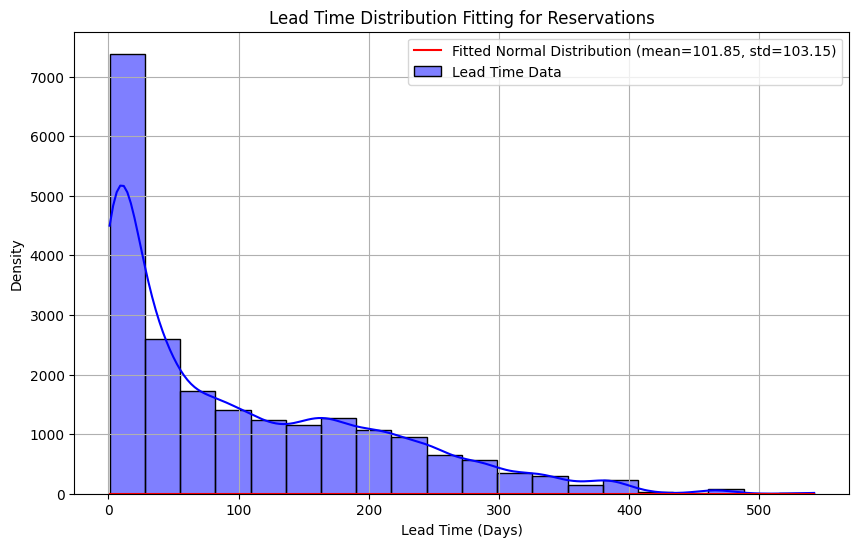

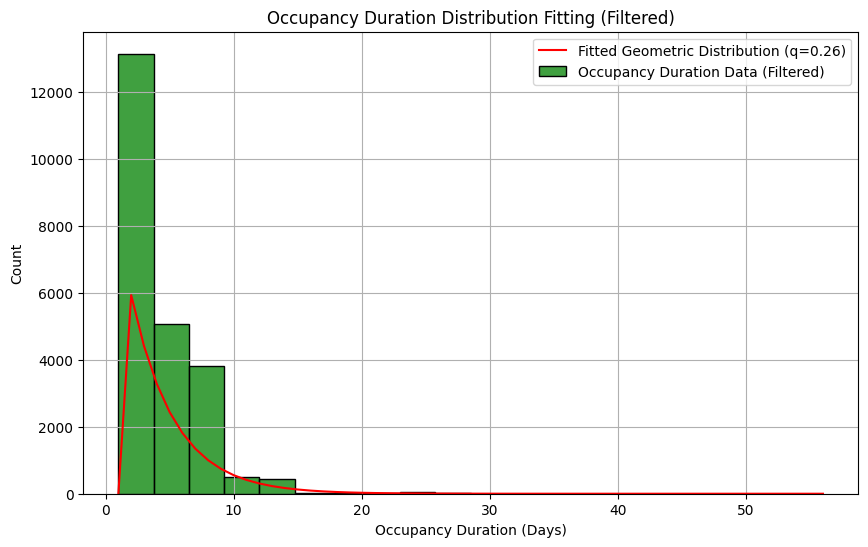

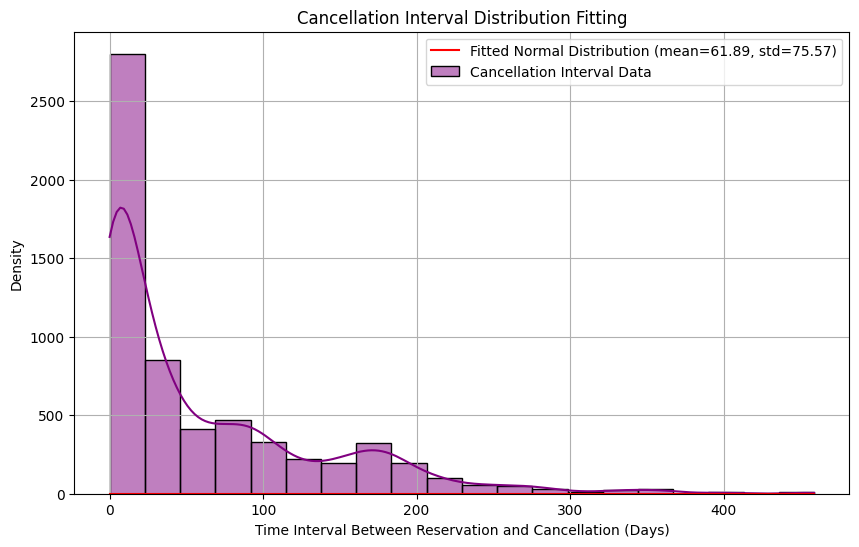

Fitted Distribution Summary:
Lead Time: Normal Distribution (mean=101.85, std=103.15)
Occupancy Duration: Geometric Distribution (q=0.26)
Cancellation Interval: Normal Distribution (mean=61.89, std=75.57)


In [25]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the reservation flow data
reservation_data = pd.read_csv('type_a_reservations_summary_with_cancel_info_dates.csv')

# Convert date columns to datetime format for accurate operations
reservation_data['Reservation Day'] = pd.to_datetime(reservation_data['Reservation Day'])
reservation_data['Check-in Day'] = pd.to_datetime(reservation_data['Check-in Day'])
reservation_data['Cancel_Date'] = pd.to_datetime(reservation_data['Cancel_Date'])

# Filter out only reservations (exclude walk-ins)
reservations_only = reservation_data[reservation_data['Type_Marked'] == 'Reservation']

# Fit reservation arrival flow (Lead Time Distribution)
lead_times = reservations_only['Lead_Time'].dropna()
lead_time_mean, lead_time_std = stats.norm.fit(lead_times)

# Plot the lead time distribution and fitted normal distribution
plt.figure(figsize=(10, 6))
sns.histplot(lead_times, bins=20, kde=True, color='blue', label='Lead Time Data')
x_vals = np.linspace(lead_times.min(), lead_times.max(), 100)
pdf_vals = stats.norm.pdf(x_vals, lead_time_mean, lead_time_std)
plt.plot(x_vals, pdf_vals, color='red', label=f'Fitted Normal Distribution (mean={lead_time_mean:.2f}, std={lead_time_std:.2f})')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Density')
plt.title('Lead Time Distribution Fitting for Reservations')
plt.legend()
plt.grid()
plt.show()

# Fit occupancy duration distribution for both reservations and walk-ins (exclude those with occupancy duration of 0)
occupancy_durations = reservation_data['Occupancy_duration'].dropna()
occupancy_durations_filtered = occupancy_durations[occupancy_durations > 0]

# Estimate parameter q of geometric distribution (mean duration = 1 / q)
mean_duration_filtered = occupancy_durations_filtered.mean()
q_filtered = 1 / mean_duration_filtered

# Plot the filtered occupancy duration and fitted geometric distribution
plt.figure(figsize=(10, 6))
sns.histplot(occupancy_durations_filtered, bins=20, kde=False, color='green', label='Occupancy Duration Data (Filtered)')
x_vals = np.arange(occupancy_durations_filtered.min(), occupancy_durations_filtered.max() + 1)
pmf_vals = stats.geom.pmf(x_vals - 1, q_filtered)
plt.plot(x_vals, pmf_vals * len(occupancy_durations_filtered), color='red', label=f'Fitted Geometric Distribution (q={q_filtered:.2f})')
plt.xlabel('Occupancy Duration (Days)')
plt.ylabel('Count')
plt.title('Occupancy Duration Distribution Fitting (Filtered)')
plt.legend()
plt.grid()
plt.show()

# Fit cancellation flow (Time Interval Between Reservation and Cancellation)
cancellation_data = reservations_only[reservations_only['Decision'] == 0]
cancellation_intervals = (cancellation_data['Cancel_Date'] - cancellation_data['Reservation Day']).dt.days.dropna()
cancellation_mean, cancellation_std = stats.norm.fit(cancellation_intervals)

# Plot the cancellation intervals and fitted normal distribution
plt.figure(figsize=(10, 6))
sns.histplot(cancellation_intervals, bins=20, kde=True, color='purple', label='Cancellation Interval Data')
x_vals = np.linspace(cancellation_intervals.min(), cancellation_intervals.max(), 100)
pdf_vals = stats.norm.pdf(x_vals, cancellation_mean, cancellation_std)
plt.plot(x_vals, pdf_vals, color='red', label=f'Fitted Normal Distribution (mean={cancellation_mean:.2f}, std={cancellation_std:.2f})')
plt.xlabel('Time Interval Between Reservation and Cancellation (Days)')
plt.ylabel('Density')
plt.title('Cancellation Interval Distribution Fitting')
plt.legend()
plt.grid()
plt.show()

# Summary of fitted distributions
print("Fitted Distribution Summary:")
print(f"Lead Time: Normal Distribution (mean={lead_time_mean:.2f}, std={lead_time_std:.2f})")
print(f"Occupancy Duration: Geometric Distribution (q={q_filtered:.2f})")
print(f"Cancellation Interval: Normal Distribution (mean={cancellation_mean:.2f}, std={cancellation_std:.2f})")

In [27]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters (based on previously fitted distributions)
lead_time_mean, lead_time_std = 50, 15  # Use fitted parameters from lead time normal distribution
q_filtered = 1 / 4.5  # Use fitted q for occupancy duration geometric distribution
cancellation_mean, cancellation_std = 20, 5  # Use fitted parameters from cancellation interval normal distribution

# 1. Truncate the lead time to 95% major part (between 2.5th and 97.5th percentiles)
lead_time_lower = stats.norm.ppf(0.025, lead_time_mean, lead_time_std)
lead_time_upper = stats.norm.ppf(0.975, lead_time_mean, lead_time_std)

# 2. Generate reservation arrivals for 365 days
np.random.seed(42)  # For reproducibility
days = 365

# Lists to store generated reservation data
reservation_data = []

for day in range(1, days + 1):
    # Generate the number of arrivals using a Poisson process
    num_arrivals = stats.poisson.rvs(mu=5)  # Mean arrivals per day, can be adjusted

    for _ in range(num_arrivals):
        # Generate lead time from truncated normal distribution
        lead_time = np.random.uniform(lead_time_lower, lead_time_upper)

        # Calculate the reservation day
        reservation_day = day - int(lead_time)
        if reservation_day < 1:
            reservation_day = 1  # Ensure reservation day is within the year

        # Generate occupancy duration from the geometric distribution
        occupancy_duration = stats.geom.rvs(q_filtered)

        # Generate cancellation decision and cancellation day if applicable
        cancellation_decision = np.random.rand() < stats.norm.cdf(day - reservation_day, cancellation_mean, cancellation_std)
        cancel_date = reservation_day + stats.norm.rvs(cancellation_mean, cancellation_std) if cancellation_decision else None

        # Ensure cancellation date is within range and after reservation day
        if cancel_date is not None:
            cancel_date = max(reservation_day, int(cancel_date))
            if cancel_date > day:
                cancel_date = day

        # Append generated reservation data
        reservation_data.append({
            'Type': True,
            'Reservation Day': pd.to_datetime(f'2023-{reservation_day // 30 + 1}-{reservation_day % 30 + 1}', errors='coerce'),
            'Check-in Day': pd.to_datetime(f'2023-{day // 30 + 1}-{day % 30 + 1}', errors='coerce'),
            'Occupancy_duration': occupancy_duration,
            'Decision': 1 if not cancellation_decision else 0,
            'Cancel_Date': pd.to_datetime(f'2023-{cancel_date // 30 + 1}-{cancel_date % 30 + 1}', errors='coerce') if cancel_date is not None else np.nan
        })

# Convert to DataFrame
reservations_df = pd.DataFrame(reservation_data)

# Save the generated reservations data in the same format as the previous real data file
reservations_df.to_csv('simulated_type_a_reservations_summary_with_cancel_info_dates.csv', index=False)